# Exponential smoothing and Holt Winters

In [1]:
from calendar import month
from pathlib import Path
from dotenv import dotenv_values

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
DATA_DIR = Path("Exponential Smoothing and Holt Winters")
DATA_PATH = dotenv_values(Path.cwd().parent.parent / ".env")["TIMESERIES_ANALYSIS_DIR"] / DATA_DIR

In [3]:
# read data
df = pd.read_csv(DATA_PATH / "weekly_customer_complaints.csv", index_col="week", parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


## Data Preprocessing

In [4]:
# set index frequency
df = df.asfreq("W-Mon")
# guarantee right variable format
df["complaints"] = df["complaints"].str.replace(",", "").astype(float)

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

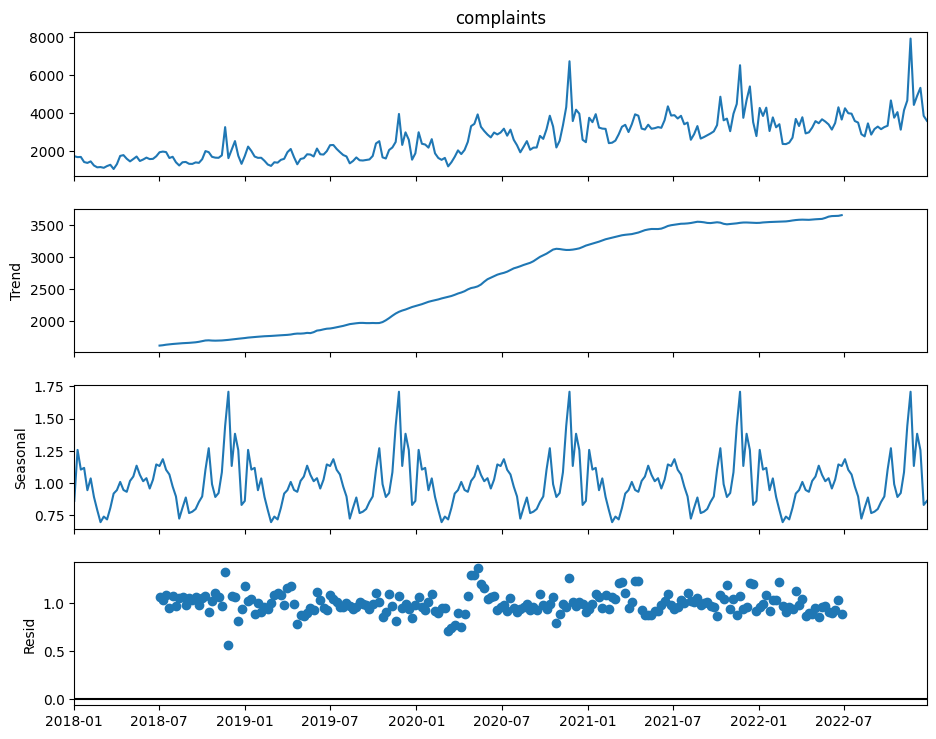

In [6]:
# seasonal decomposition plots
decomposition = seasonal_decompose(
    df["complaints"], # this must contain 2 complete cycles
    model="multiplicative", # if season is not evident, with multiplicative could have more sense
    period=52 # for weekly
)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

Spikes on Nov usually and valleys on Feb-Mar.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

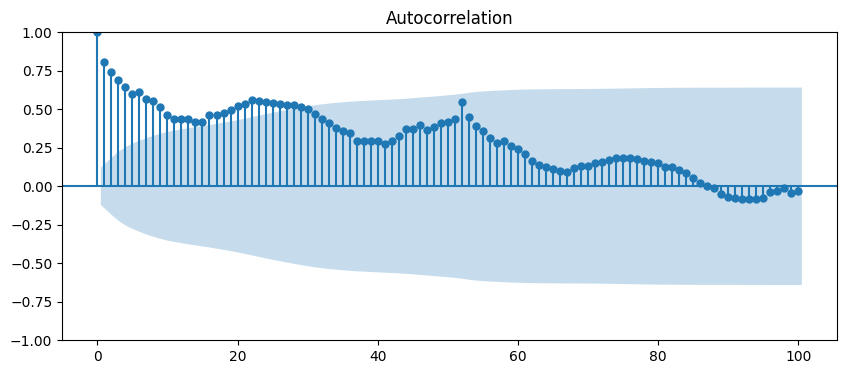

In [8]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["complaints"], lags=100, ax=ax)
plt.show()

Recent data seems like a good assest to use, and the spike on lag 52 as well.

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

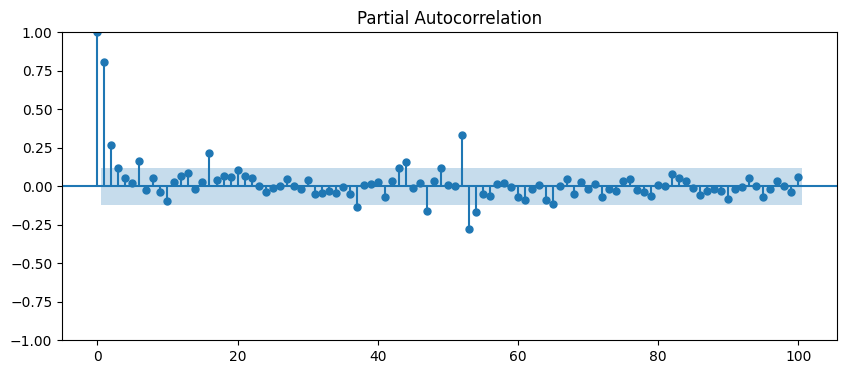

In [10]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df["complaints"], lags=100, ax=ax)
plt.show()


So to confirm, the real relation could be with lag 1-2 and lag 52-53 definitely.

##  Training and test splitting
Assuming goal is to predict next quarter (13 weeks).

In [11]:
periods = 13
train, test = df.iloc[:-periods, 0], df.iloc[-periods:, 0]

## Simple exponential smoothing
Take current value t and multiply it by alpha times delta t, t-1.

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
# fit model on train
model_simple = SimpleExpSmoothing(train).fit()
# forecast on test
preds_simple = model_simple.forecast(len(test))

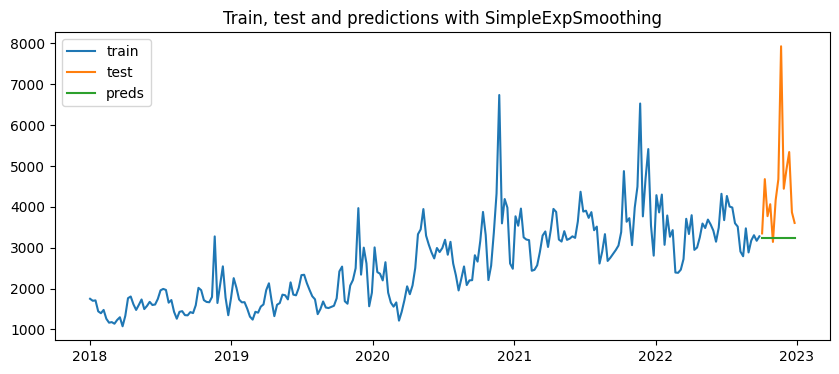

In [19]:
# plot train, test and preds
plt.figure(figsize=(10, 4))
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(preds_simple, label="preds")
plt.title("Train, test and predictions with SimpleExpSmoothing")
plt.legend()
plt.show()

## Double Exponential Smoothing
Not only smooths data, but handle trends by adding smooth level and smoothing trend. Still not handle seasonality.

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
# for double exponential just define trend
# for triple exponential define trend as well as seasonal
model_double = ExponentialSmoothing(train, trend="additive", seasonal=None).fit()
# forecast on test
preds_double = model_double.forecast(len(test))
preds_double

2022-10-03    3234.105506
2022-10-10    3232.693127
2022-10-17    3231.280747
2022-10-24    3229.868368
2022-10-31    3228.455988
2022-11-07    3227.043609
2022-11-14    3225.631229
2022-11-21    3224.218849
2022-11-28    3222.806470
2022-12-05    3221.394090
2022-12-12    3219.981711
2022-12-19    3218.569331
2022-12-26    3217.156952
Freq: W-MON, dtype: float64

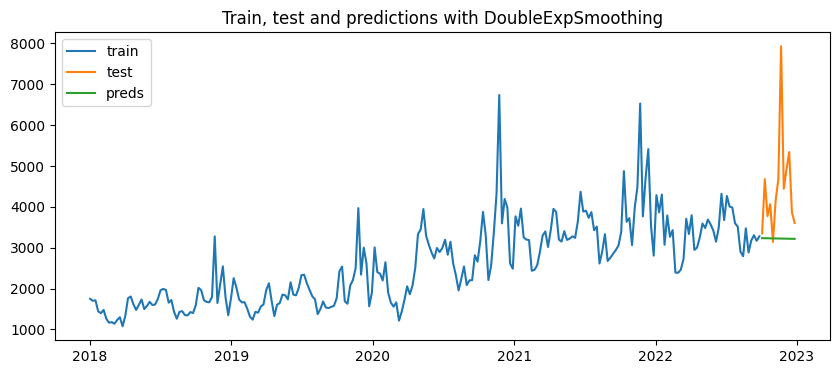

In [23]:
# plot train, test and preds
plt.figure(figsize=(10, 4))
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(preds_double, label="preds")
plt.title("Train, test and predictions with DoubleExpSmoothing")
plt.legend()
plt.show()

## Triple Exponential Smoothing
Now smooth, handle trend and handle seasonality as well. This is the HoltWinters method itself. So, it adjusts level, then updates trend, and finally adapt it over time. This method is highly effective predicting recurring paterns.

In [26]:
# for double exponential just define trend
# for triple exponential define trend as well as seasonal
model_triple = ExponentialSmoothing(
    train,
    trend="additive",
    seasonal="multiplicative", # based on series plot, check how could be the differences on cycles
    seasonal_periods=52
).fit()
# forecast on test
preds_triple = model_triple.forecast(len(test))
preds_triple

2022-10-03    4017.738377
2022-10-10    5022.582208
2022-10-17    3903.956160
2022-10-24    3503.493210
2022-10-31    3401.504617
2022-11-07    4218.575909
2022-11-14    5303.358805
2022-11-21    7200.621705
2022-11-28    4309.556057
2022-12-05    5262.119512
2022-12-12    5234.333391
2022-12-19    3418.339801
2022-12-26    3256.657741
Freq: W-MON, dtype: float64

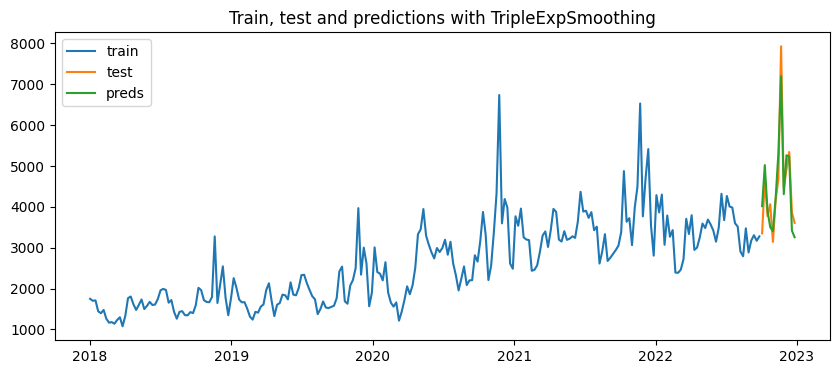

In [27]:
# plot train, test and preds
plt.figure(figsize=(10, 4))
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(preds_triple, label="preds")
plt.title("Train, test and predictions with TripleExpSmoothing")
plt.legend()
plt.show()

Too adjusted.